# Demonstration of deconvolving PAX data
For details, see the manuscript

In [1]:
# Install pax_deconvolve
#!pip install git+https://github.com/dhigley6/PAX2

In [2]:
# import standard python modules:
import numpy as np 
%matplotlib inline
%load_ext tensorboard

# import custom python modules:
from pax_deconvolve.pax_simulations import simulate_pax
from pax_deconvolve.deconvolution import deconvolvers, assess_convergence
from pax_deconvolve import visualize

# set simulation parameters
LOG10_NUM_ELECTRONS = 5.0  # 10^7 detected electrons (over entire dateset)
RIXS_MODEL = 'schlappa'  # use RIXS model chosen to approximate that in Schlappa's paper
PHOTOEMISSION_MODEL = 'ag'   # use Ag 3d core levels as model photoemission
NUM_SIMULATIONS = 100    # Number of PAX spectra to simulate
ENERGY_LOSS = np.arange(-8, 10, 0.01)  # energy loss values of RIXS to simulate over
REGULARIZATION_STRENGTHS = np.logspace(-3, -1, 10)  # Regularization strengths to try
ITERATIONS = 100    # Number of iterations to run simulations for
CV_FOLD = 3   # Number of folds to use for cross validation

In [3]:
# Simulate some PAX data 
impulse_response, pax_spectra, xray_xy = simulate_pax.simulate_from_presets(
    LOG10_NUM_ELECTRONS,
    RIXS_MODEL,
    PHOTOEMISSION_MODEL,
    NUM_SIMULATIONS,
    ENERGY_LOSS
)

In [4]:
# Assess convergence of PAX data

# Run convergence assessment
assess_convergence.run(
    impulse_response,
    pax_spectra,
    xray_xy,
    REGULARIZATION_STRENGTHS,
    ITERATIONS
)

# Show data which can be used to assess convergence (see manuscript):
%tensorboard --logdir logdir
# Since this is simulated data, the deconvolved mean squared error is also shown,
# but that would usually not be accessible since the ground truth is usually
# unknown

Reusing TensorBoard on port 6006 (pid 57888), started 0:08:43 ago. (Use '!kill 57888' to kill it.)

In [5]:
#  Deconvolve PAX data, determining regulariation strength by cross validation of how well
#  we can estimate unseen data from the deconvolved result

# Run deconvolution
deconvolver = deconvolvers.LRFisterGrid(
        impulse_response['x'],
        impulse_response['y'],
        pax_spectra['x'],
        REGULARIZATION_STRENGTHS,
        ITERATIONS,
        xray_xy['y'],
        CV_FOLD
)
_ = deconvolver.fit(np.array(pax_spectra['y']))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished


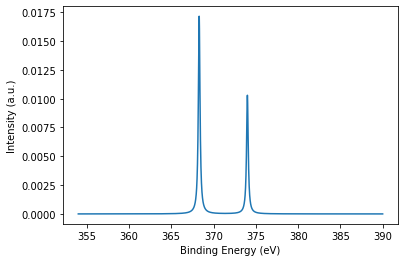

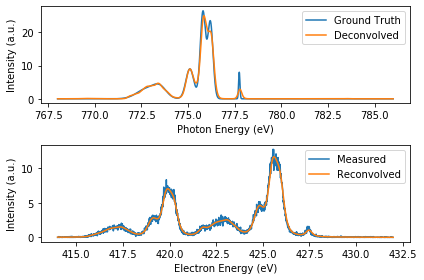

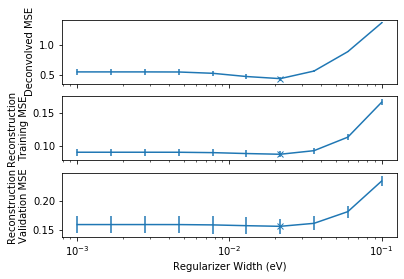

In [6]:
# Plot results
visualize.plot_photoemission(deconvolver)
visualize.plot_result(deconvolver)
visualize.plot_cv(deconvolver)

In [7]:
# save result for further processing
deconvolved_x = deconvolver.deconvolved_x    # Photon energies of deconvolved result
deconvolved_y = deconvolver.deconvolved_y_   # intensities of deconvolved result

In [8]:
dir(deconvolver)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_cv_deconvolution_estimator',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_record_deconvolution_results',
 'best_regularization_strength_',
 'convolved_x',
 'cv_',
 'cv_folds',
 'cv_std_',
 'deconvolved_mse_',
 'deconvolved_mse_std_',
 'deconvolved_x',
 'deconvolved_y_',
 'fit',
 'get_params',
 'ground_truth_y',
 'impulse_response_x',
 'impulse_response_y',
 'iterations',
 'measured_y_',
 'predict',
 'reconstruction_train_mse_',
 'reconstruction_train_mse_std_',
 'reconstruction_y_',
 'regularization_strengths',
 'set_params']

In [9]:
len(deconvolver.deconvolved_y_)


1800

In [10]:
len(deconvolver.ground_truth_y)

1800

In [11]:
len(deconvolver.measured_y_)

1800